<a href="https://colab.research.google.com/github/aaart42/trading_pub/blob/main/RiskPremiaResearch_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
devtools::install_github("RWLab/tlaqData", force = TRUE)

library(tlaqData)
library(tidyverse)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpY9YVi1/remotesf93123e622/RWLab-tlaqData-1a8bfdc/DESCRIPTION’ ... OK
* preparing ‘tlaqData’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘tlaqData_1.6.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Install if needed
install.packages("yfR")

# Load library
library(yfR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’, ‘xts’, ‘TTR’, ‘snakecase’, ‘furrr’, ‘future’, ‘zoo’, ‘quantmod’, ‘pingr’, ‘janitor’




fetch data

In [11]:
# Define tickers
tickers <- c("VTI", "GLD", "TLT")

# Download max data (adjust freq_data if you want weekly/monthly instead of daily)
data <- yf_get(tickers = tickers,
               first_date = "2001-01-01",  # Early date for max history
               last_date = Sys.Date())     # Up to today

# View the first few rows (already in long format)
head(data)



── Running yfR for 3 stocks | 2001-01-01 --> 2025-09-26 (9034 days) ──



ℹ Downloading data for benchmark ticker ^GSPC

ℹ (1/3) Fetching data for GLD

✔ 	- found cache file (2004-11-18 --> 2025-09-25)

✔ 	- got 5246 valid rows (2004-11-18 --> 2025-09-25)

✔ 	- got 84% of valid prices -- Good job !

ℹ (2/3) Fetching data for TLT

✔ 	- found cache file (2002-07-30 --> 2025-09-25)

✔ 	- got 5828 valid rows (2002-07-30 --> 2025-09-25)

✔ 	- got 94% of valid prices -- Got it!

ℹ (3/3) Fetching data for VTI

✔ 	- found cache file (2001-06-15 --> 2025-09-25)

✔ 	- got 6106 valid rows (2001-06-15 --> 2025-09-25)

✔ 	- got 98% of valid prices -- You got it !

ℹ Binding price data



── Diagnostics ─────────────────────────────────────────────────────────────────

✔ Returned dataframe with 17180 rows -- Time for some tea?

ℹ Using 2.3 MB at /tmp/RtmpY9YVi1/yf_cache for 4 cache files

ℹ Out of 3 requested tickers, you got 3 (100%)



ticker,ref_date,price_open,price_high,price_low,price_close,volume,price_adjusted,ret_adjusted_prices,ret_closing_prices,cumret_adjusted_prices
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLD,2004-11-18,44.43,44.49,44.07,44.38,5992000,44.38,NA,NA,1.000000
GLD,2004-11-19,44.49,44.92,44.47,44.78,11655300,44.78,0.009013017,0.009013017,1.009013
GLD,2004-11-22,44.75,44.97,44.74,44.95,11996000,44.95,0.003796382,0.003796382,1.012844
GLD,2004-11-23,44.88,44.92,44.72,44.75,3169200,44.75,-0.004449405,-0.004449405,1.008337
GLD,2004-11-24,44.93,45.05,44.79,45.05,6105100,45.05,0.006703894,0.006703894,1.015097
GLD,2004-11-26,45.25,45.60,45.06,45.29,3097700,45.29,0.005327451,0.005327451,1.020505


Test it with one asset only, to make life easier

In [12]:
GLD <- data %>%
  filter(ticker == "GLD") %>%
  select(ref_date, price_adjusted)

In [25]:
GLD <- GLD %>%
  mutate(
    returns = log(price_adjusted / lag(price_adjusted, 30)),
    forward_returns = log(lead(price_adjusted, 30) / price_adjusted)
  ) %>%
  na.omit()

`geom_smooth()` using formula = 'y ~ x'


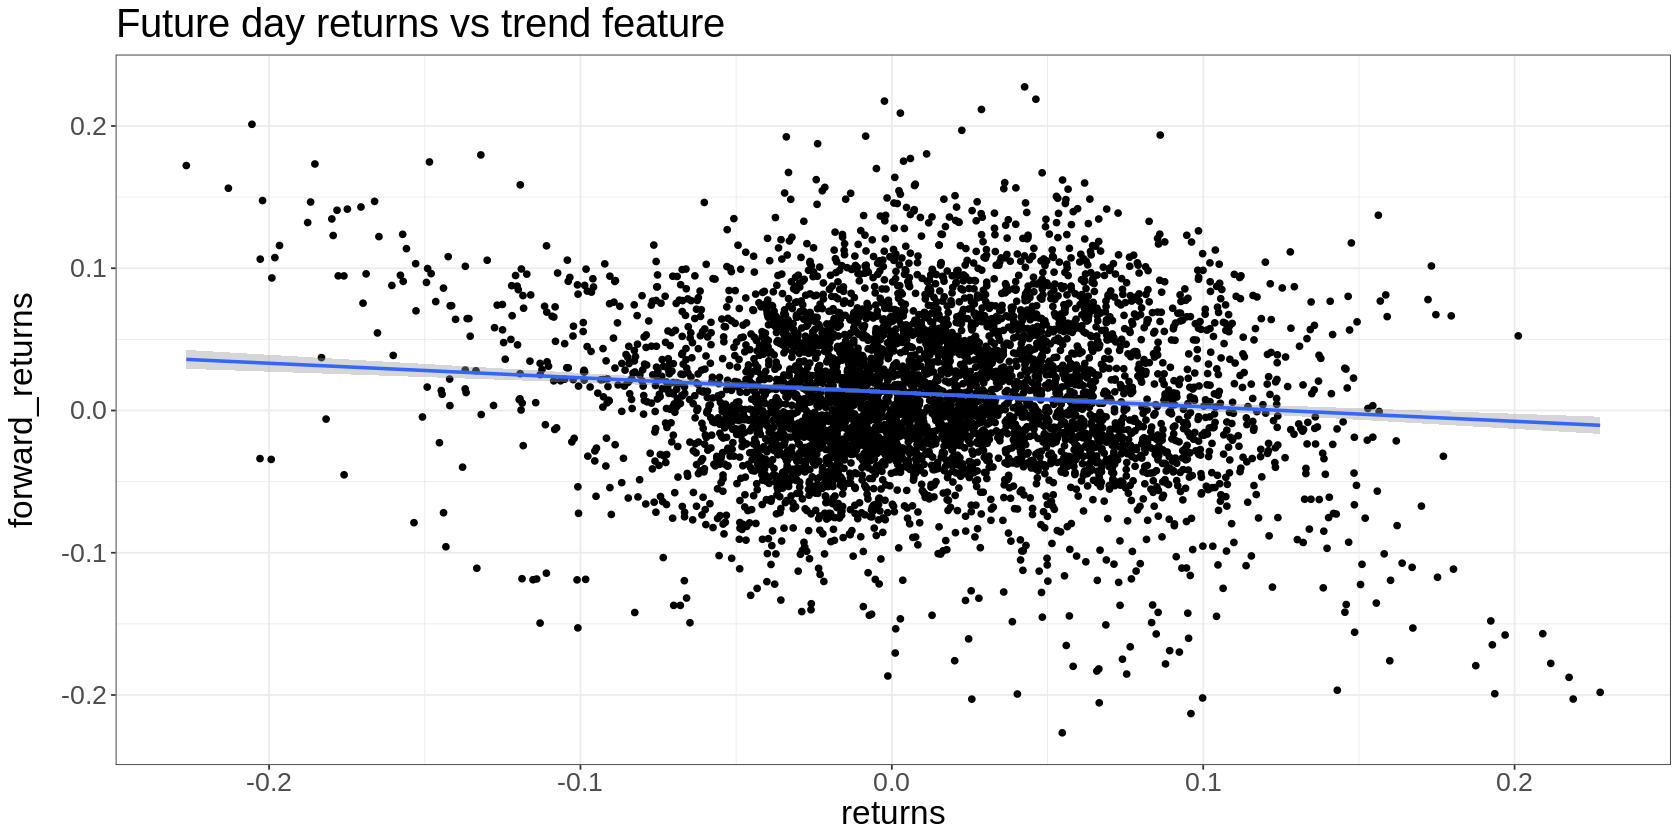

In [26]:
GLD %>%
  ggplot(aes(x=returns, y = forward_returns)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  ggtitle('Future day returns vs trend feature')

Now we do that for all 3 assets

`geom_smooth()` using formula = 'y ~ x'


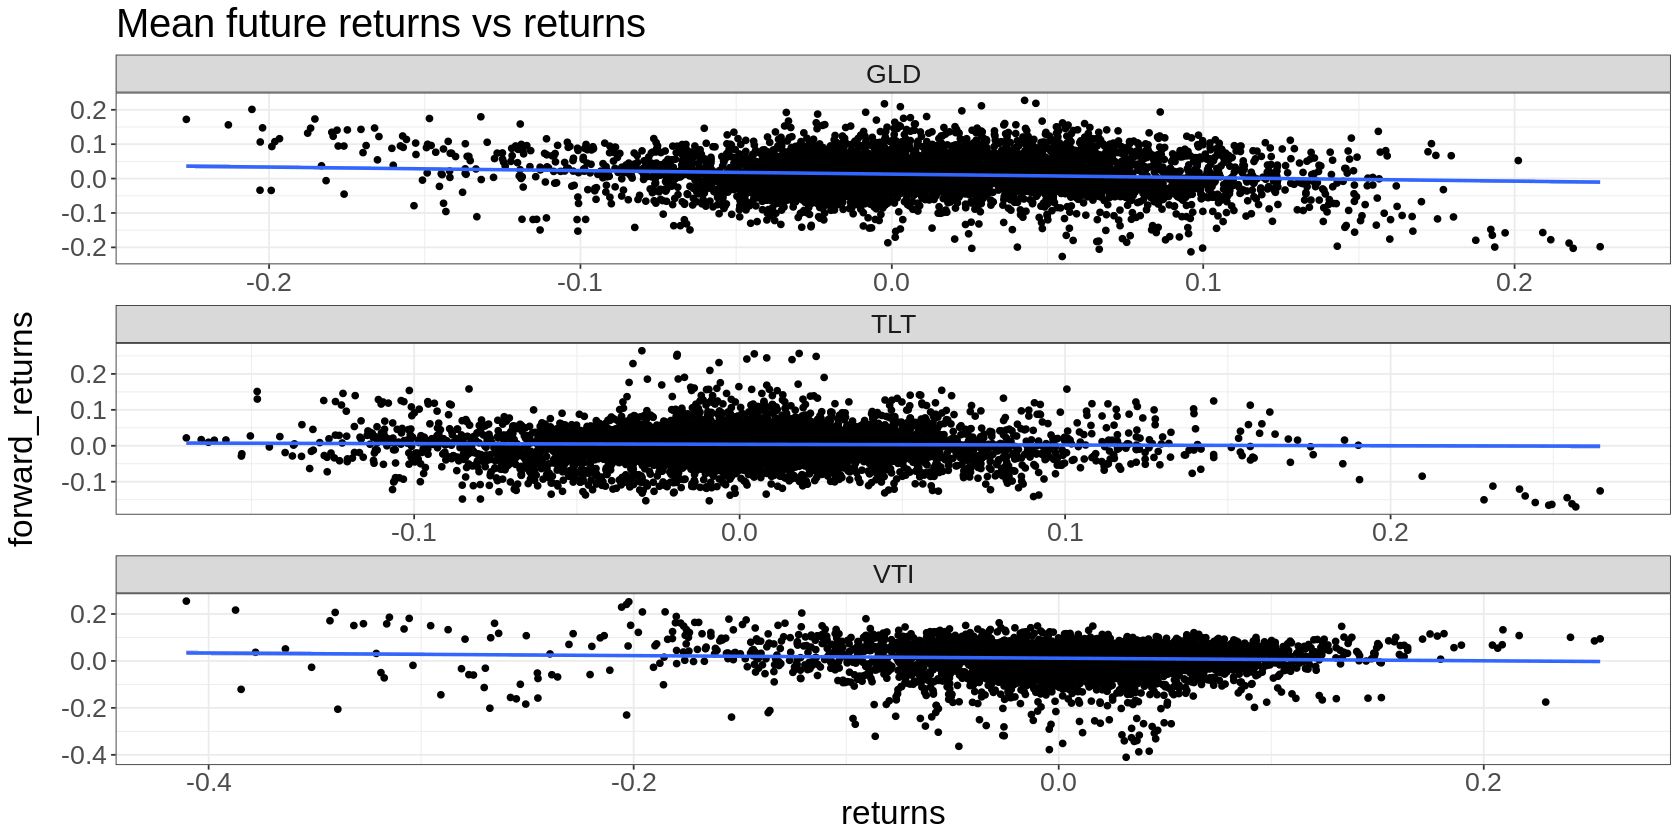

In [27]:
data %>%
  group_by(ticker) %>%
  arrange(ref_date) %>%
  mutate(
    returns = log(price_adjusted / lag(price_adjusted, 30)),
    forward_returns = log(lead(price_adjusted, 30) / price_adjusted)
  ) %>%
  na.omit() %>%
  ggplot(aes(x=returns, y=forward_returns)) + geom_point() + geom_smooth(method='lm') +
    facet_wrap(~ticker, scales='free', nrow = 3) +
    ggtitle('Mean future returns vs returns')

Remove overlaps and plot it again

`geom_smooth()` using formula = 'y ~ x'


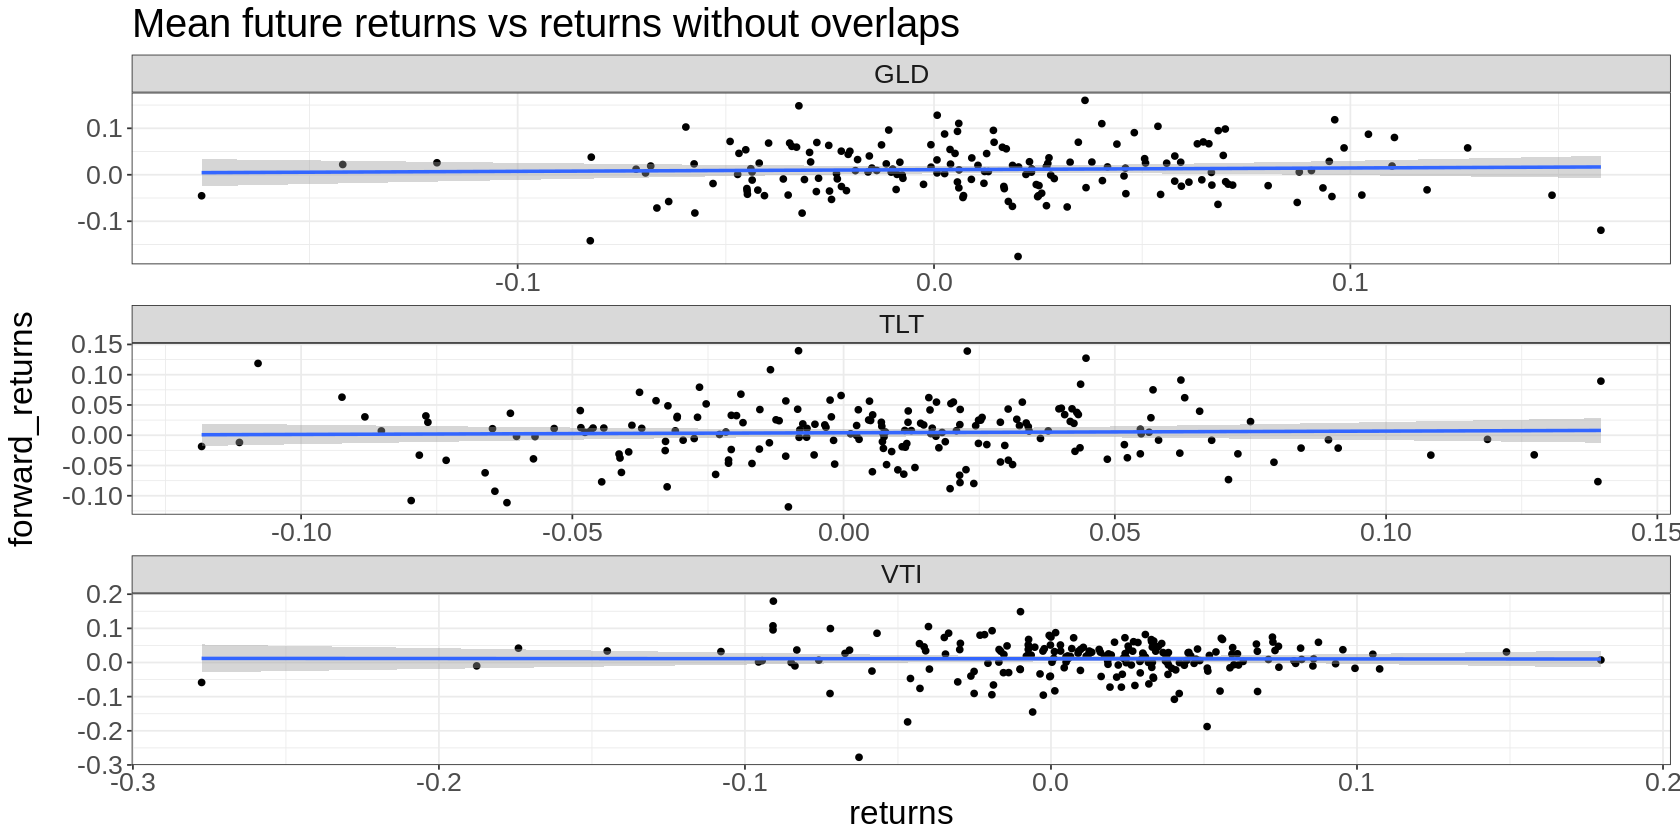

In [28]:
lookback = 30
look_forward = 30

data %>%
  group_by(ticker) %>%
  arrange(ref_date) %>%
  mutate(
    row = row_number(),
    returns = log(price_adjusted / lag(price_adjusted, lookback)),
    forward_returns = log(lead(price_adjusted, look_forward) / price_adjusted)
  ) %>%
  na.omit() %>%
  filter(row_number() %% lookback == 1) %>%
  ggplot(aes(x=returns, y=forward_returns)) + geom_point() + geom_smooth(method='lm') +
    facet_wrap(~ticker, scales='free', nrow = 3) +
    ggtitle('Mean future returns vs returns without overlaps')

In [29]:
install.packages("RcppRoll")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [30]:
library(RcppRoll)  # Für roll_sd

`geom_smooth()` using formula = 'y ~ x'


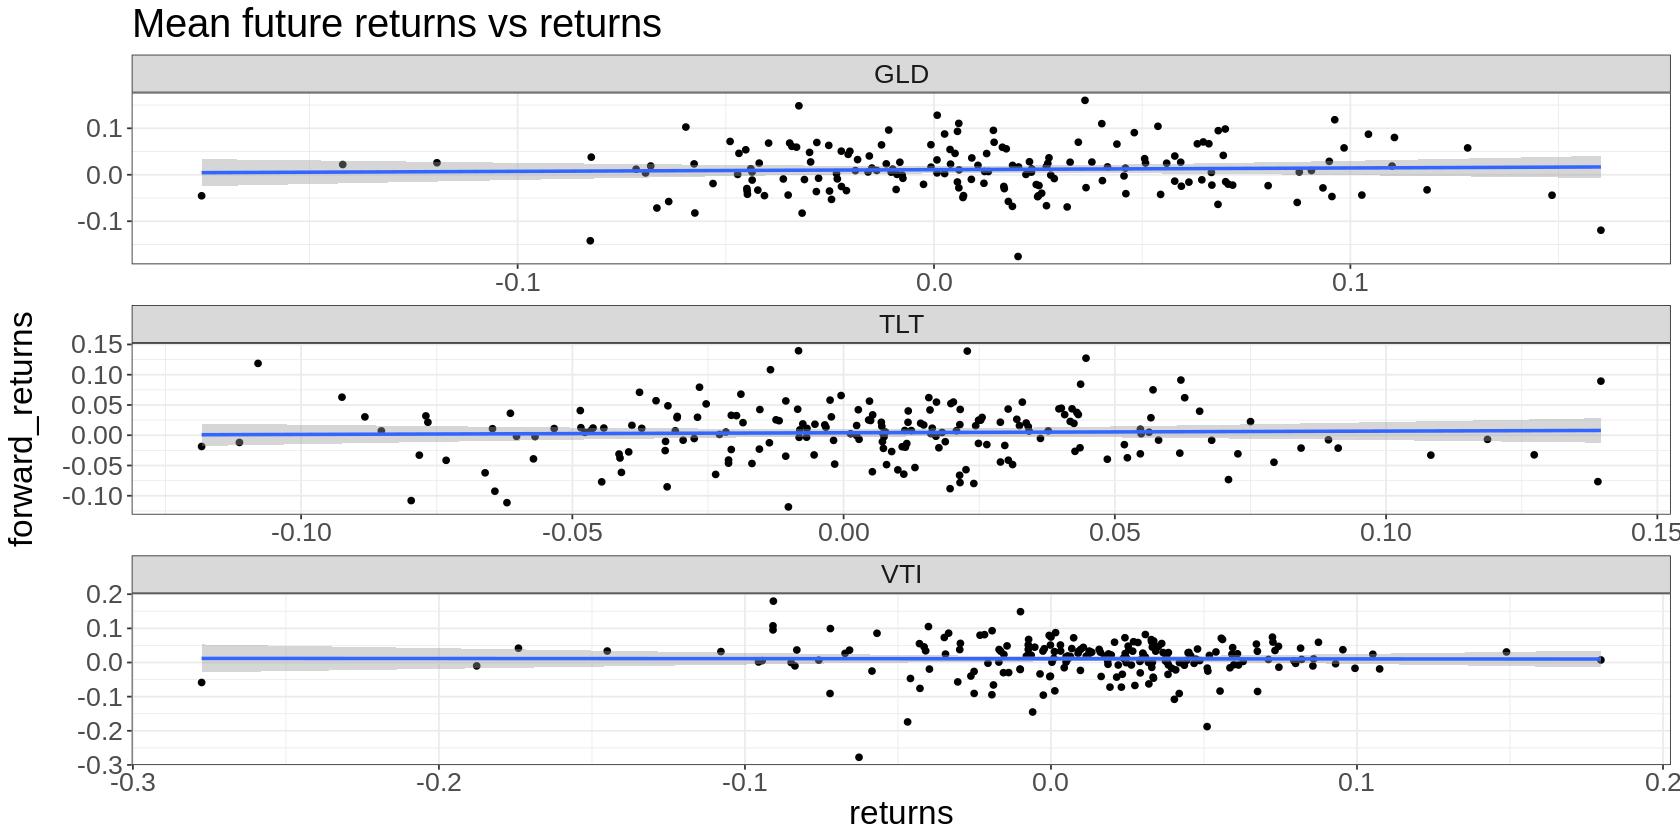

In [31]:
lookback = 30
look_forward = 30

data %>%
  group_by(ticker) %>%
  arrange(ref_date) %>%
  mutate(
    returns = log(price_adjusted / lag(price_adjusted, lookback)),
    forward_returns = log(lead(price_adjusted, look_forward) / price_adjusted),
  ) %>%
  na.omit() %>%
  filter(row_number() %% lookback == 1) %>%
  ggplot(aes(x=returns, y=forward_returns)) + geom_point() + geom_smooth(method='lm') +
    facet_wrap(~ticker, scales='free', nrow = 3) +
    ggtitle('Mean future returns vs returns')

`geom_smooth()` using formula = 'y ~ x'


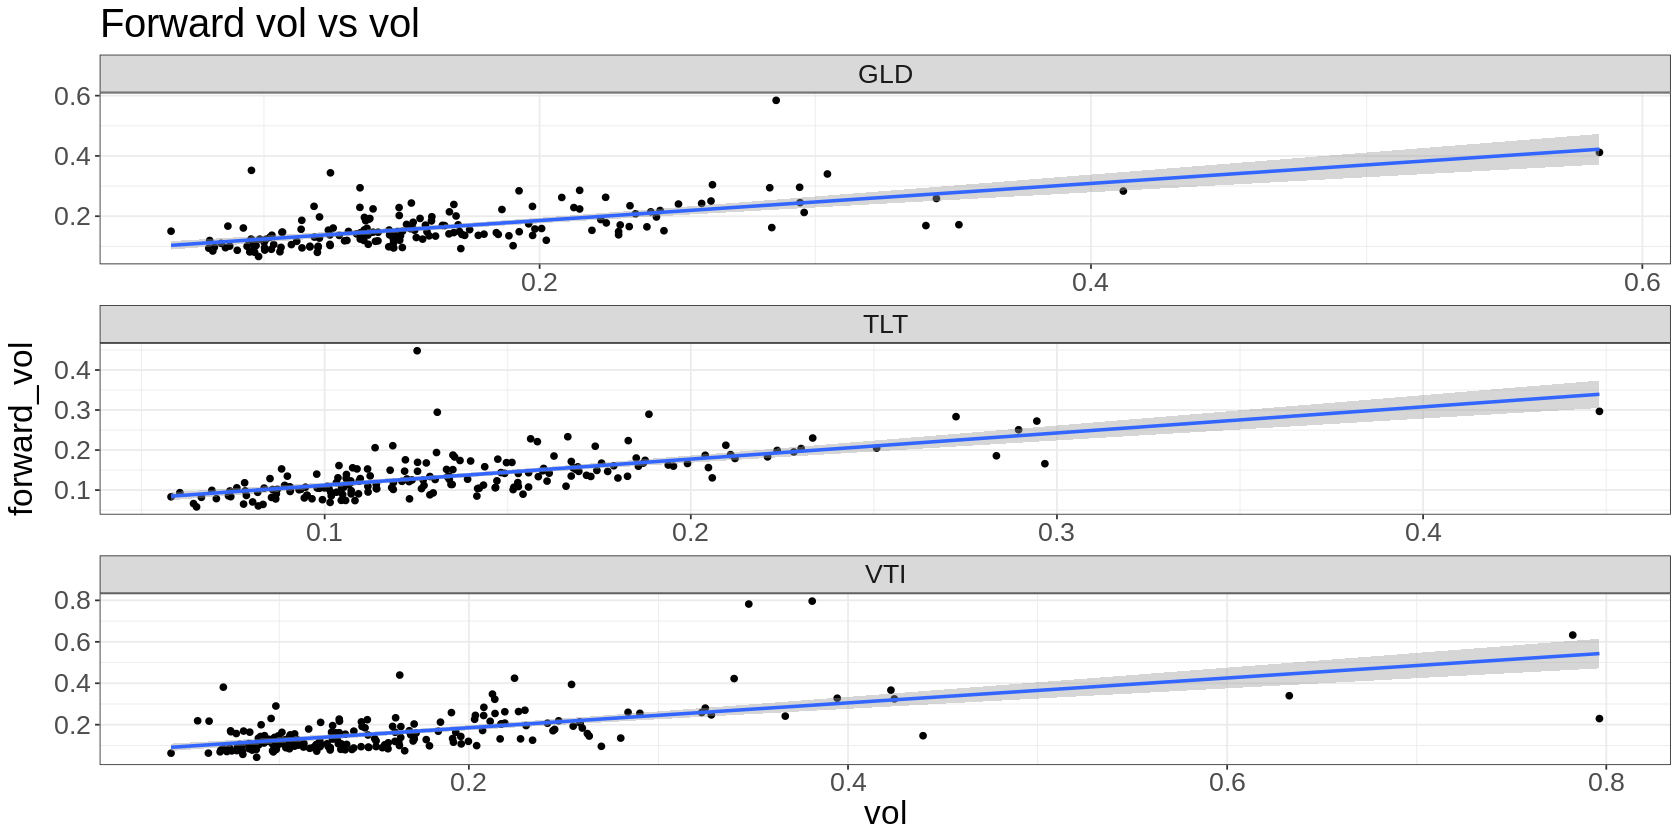

In [32]:
data %>%
  group_by(ticker) %>%
  arrange(ref_date) %>%
  mutate(
    returns = log(price_adjusted / lag(price_adjusted)),
    vol = roll_sd(returns, lookback, fill = NA, align = "right") * sqrt(252),
    forward_vol = lead(vol, look_forward),
  ) %>%
  na.omit() %>%
  filter(row_number() %% lookback == 1) %>%
  ggplot(aes(x=vol, y=forward_vol)) + geom_point() + geom_smooth(method='lm') +
    facet_wrap(~ticker, scales='free', nrow = 3) +
    ggtitle('Forward vol vs vol')